### Step 3: Competitor Analysis  
**Objective**: Identify how leading brands differentiate themselves across segments, analyze gaps in feature offerings, and uncover missed opportunities in feature-price combinations.  

---

### **Key Tasks**

#### **1. Identify Brand-Specific Strengths**
- **Proportion of Premium Features by Brand:**
  - Calculate the percentage of phones with features like 5G, NFC, and fast charging for each brand within each price segment.
  - Insight: Identify brands excelling in premium features.

- **Processor Performance by Brand:**
  - Summarize processor-related attributes (brand, number of cores, speed) by brand and segment.
  - Insight: Highlight brands offering high-performance processors in budget or mid-range segments.

---

#### **2. Price Comparison for Similar Features**
- **Group Phones with Similar Features:**
  - Standardize and compare feature combinations (e.g., 5G, RAM, internal memory, fast charging, screen size).
  - Insight: Compare average prices for similar-feature phones across brands.


# Import Libraries

In [1]:
import os

import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.preprocessing import PowerTransformer

from src.utils.utils import (
    get_data,
    outlier_overview, 
    export_data, 
    prepare_segment_trends_data, 
    numerical_categorical_analysis,
    anova_test,
    test_for_normality,
    mann_whitney_test,
    numerical_analysis,
    two_sample_independent_ttest,
    levene_test,
    categorical_analysis
    
)

from scipy.stats import probplot, pearsonr

from src.constants.constants import FIG_SIZE

In [2]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', None) 

# Read the Data

In [3]:
df = get_data("smartphone_cleaned_v5", "processed")
analysis_df = prepare_segment_trends_data(df)
analysis_df.head()

,brand_name,model,price,rating,has_5g,has_nfc,has_ir_blaster,processor_brand,num_cores,processor_speed,battery_capacity,fast_charging_available,fast_charging,ram_capacity,internal_memory,screen_size,refresh_rate,resolution,num_rear_cameras,num_front_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,extended_upto
0,oneplus,OnePlus 11 5G,54999,89.0,True,True,False,snapdragon,8.0,3.2,5000.0,1,100.0,12.0,256.0,6.70,120,1440 x 3216,3,1.0,android,50.0,16.0,0,0.0
1,oneplus,OnePlus Nord CE 2 Lite 5G,19989,81.0,True,False,False,snapdragon,8.0,2.2,5000.0,1,33.0,6.0,128.0,6.59,120,1080 x 2412,3,1.0,android,64.0,16.0,1,1024.0
2,samsung,Samsung Galaxy A14 5G,16499,75.0,True,False,False,exynos,8.0,2.4,5000.0,1,15.0,4.0,64.0,6.60,90,1080 x 2408,3,1.0,android,50.0,13.0,1,1024.0
3,motorola,Motorola Moto G62 5G,14999,81.0,True,False,False,snapdragon,8.0,2.2,5000.0,1,NaN,6.0,128.0,6.55,120,1080 x 2400,3,1.0,android,50.0,16.0,1,1024.0
4,realme,Realme 10 Pro Plus,24999,82.0,True,False,False,dimensity,8.0,2.6,5000.0,1,67.0,6.0,128.0,6.70,120,1080 x 2412,3,1.0,android,108.0,16.0,0,0.0


In [4]:
budget = (
    analysis_df
    .loc[lambda x: x['price'] <= 23000]
)

In [5]:
mid = (
    analysis_df
    .loc[lambda x: (x['price'] > 23000) & (x['price'] <= 50000)]
)

In [6]:
premium = (
    analysis_df
    .loc[lambda x: x['price'] > 50000]
)

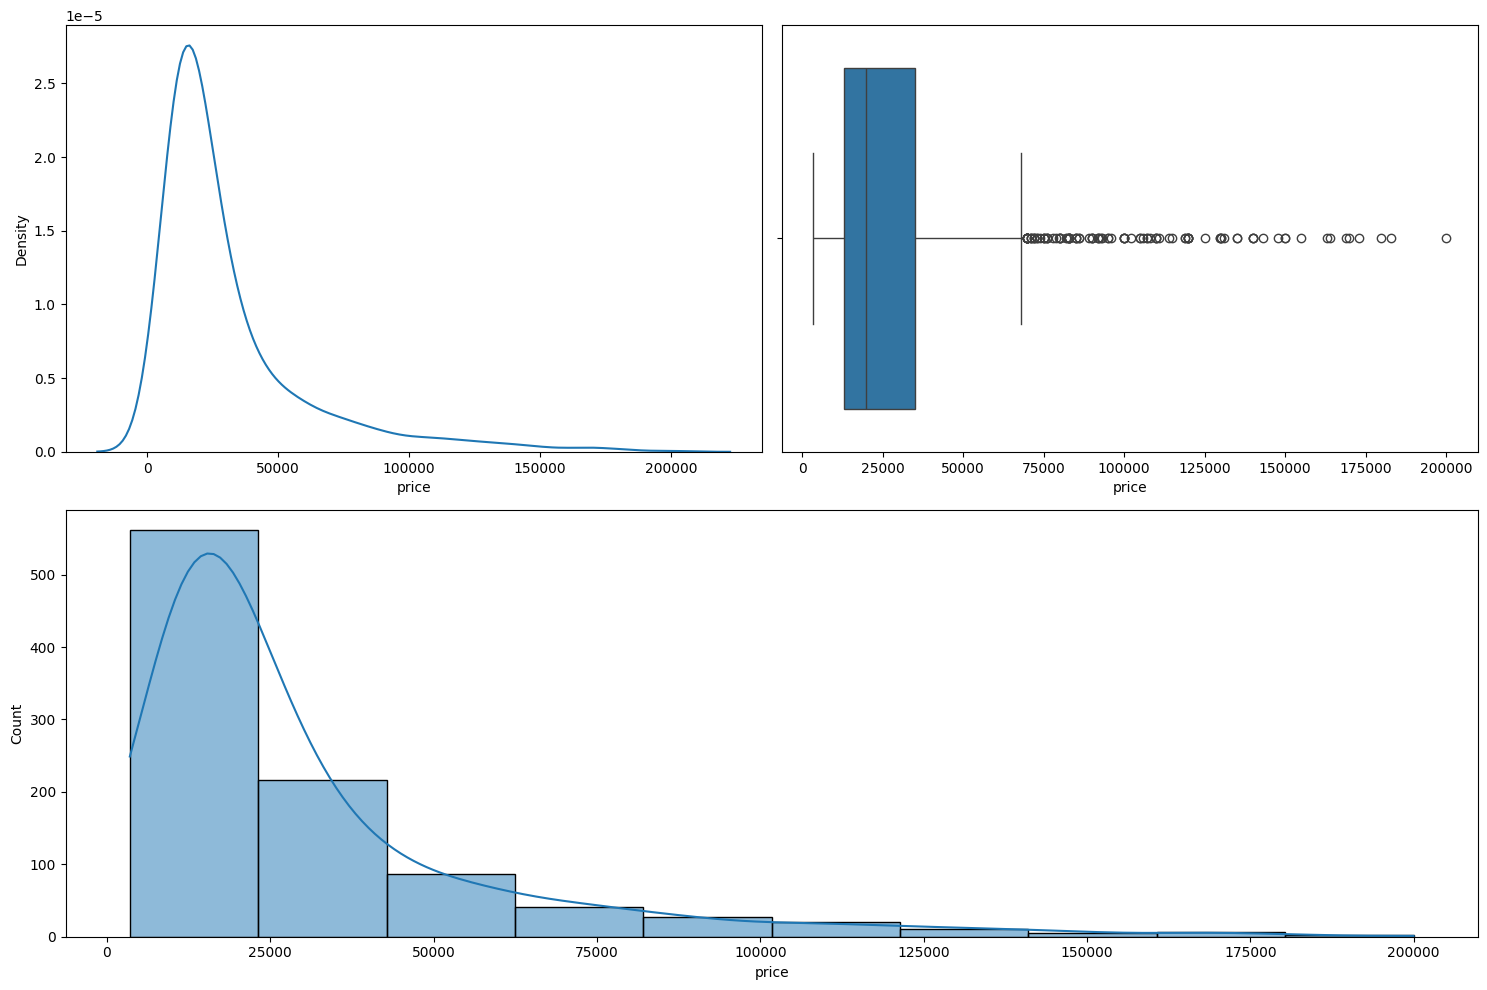

In [7]:
numerical_analysis(analysis_df, "price", bins = 10)

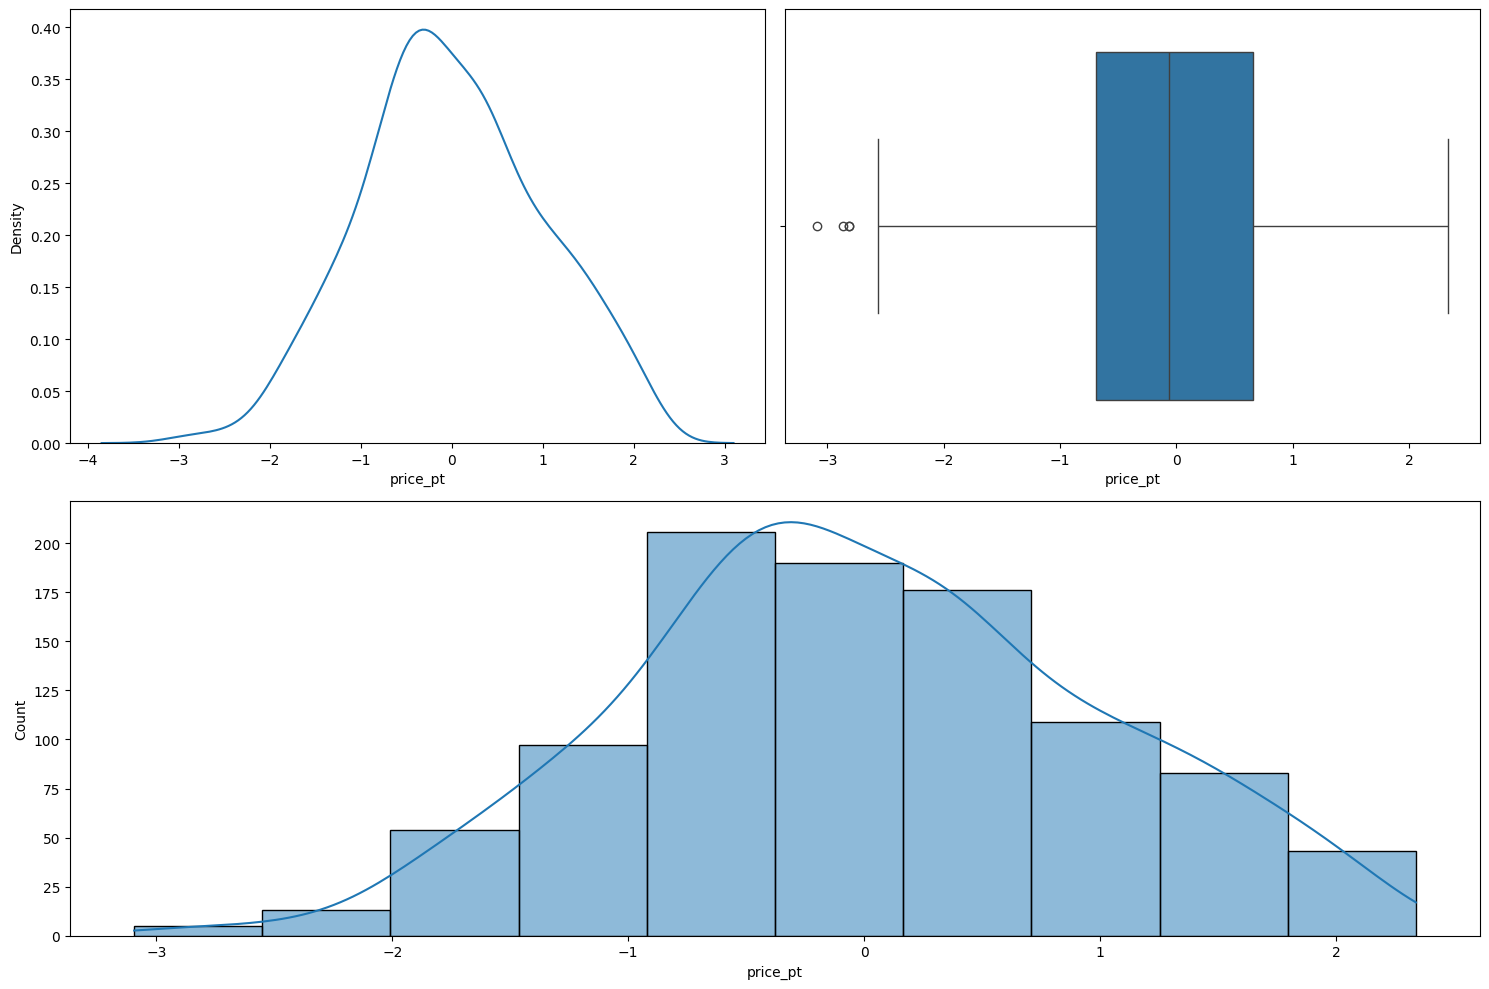

In [8]:
pt = PowerTransformer(method = "yeo-johnson")

analysis_df = analysis_df.assign(price_pt = lambda df: pt.fit_transform(analysis_df[["price"]]))

numerical_analysis(analysis_df, "price_pt", bins=10)

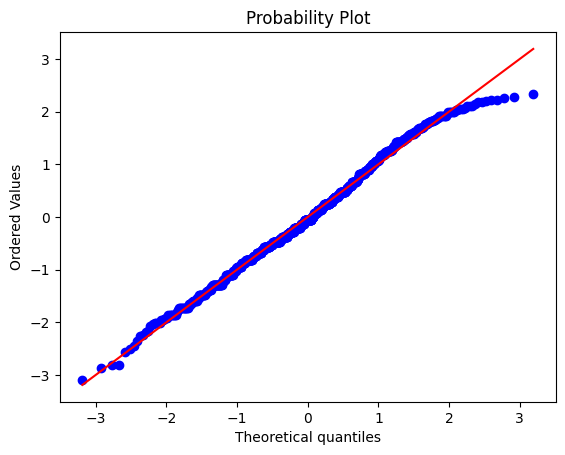

In [9]:
# plot QQ plot for the price

probplot(analysis_df["price_pt"], plot = plt)
plt.show()

In [10]:
test_for_normality(dataframe = analysis_df, column_name = "price_pt")

Jarque Bera Test for Normality
0.07228337941564213
Fail to reject the null hypothesis. The data is normally distributed.


## Observations

- Price column is positively skewed.
- Price column is normally distributed after applying yeo-johnson power transformer.

In [11]:
analysis_df.brand_name.nunique()

45

In [12]:
budget.groupby(by = "brand_name").size()

brand_name
blackview     1
blu           1
cat           1
cola          1
doogee        1
duoqin        1
gionee        3
google        3
honor         6
huawei        5
ikall         3
infinix      28
iqoo         12
itel         10
jio           4
lava          4
leeco         1
letv          3
lyf           2
micromax      3
motorola     34
nokia         7
oneplus      13
oppo         51
oukitel       1
poco         30
realme       74
redmi         3
samsung      69
sony          2
tcl           1
tecno        30
vivo         65
xiaomi       87
zte           1
dtype: int64

## Assumptions

- For brand analysis we will be considering only for brands with minimum 10 smartphones.  

# Identify brand-specific strengths

## Proportion of Premium Features by Brand and Segment

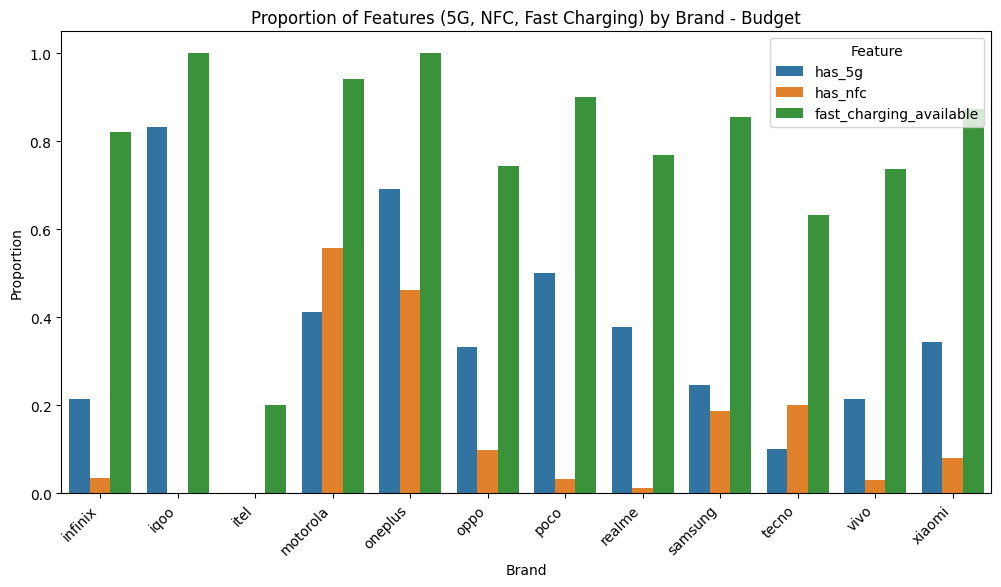

In [13]:
# 5G,nfc and fast_charging for budget

plt.figure(figsize=(12, 6))

sns.barplot(
    data=(
        budget[budget['brand_name'].isin(budget['brand_name'].value_counts()[budget['brand_name'].value_counts() >= 10].index)]
        .groupby(by="brand_name")[['has_5g', 'has_nfc', 'fast_charging_available']]
        .mean()
        .reset_index()
        .melt(id_vars='brand_name', var_name='feature', value_name='proportion')
    ),
    x='brand_name', 
    y='proportion', 
    hue='feature'
)

# Adding labels and title
plt.xticks(rotation=45, ha='right')
plt.title("Proportion of Features (5G, NFC, Fast Charging) by Brand - Budget")
plt.ylabel("Proportion")
plt.xlabel("Brand")
plt.legend(title='Feature')

# Show plot
plt.show()

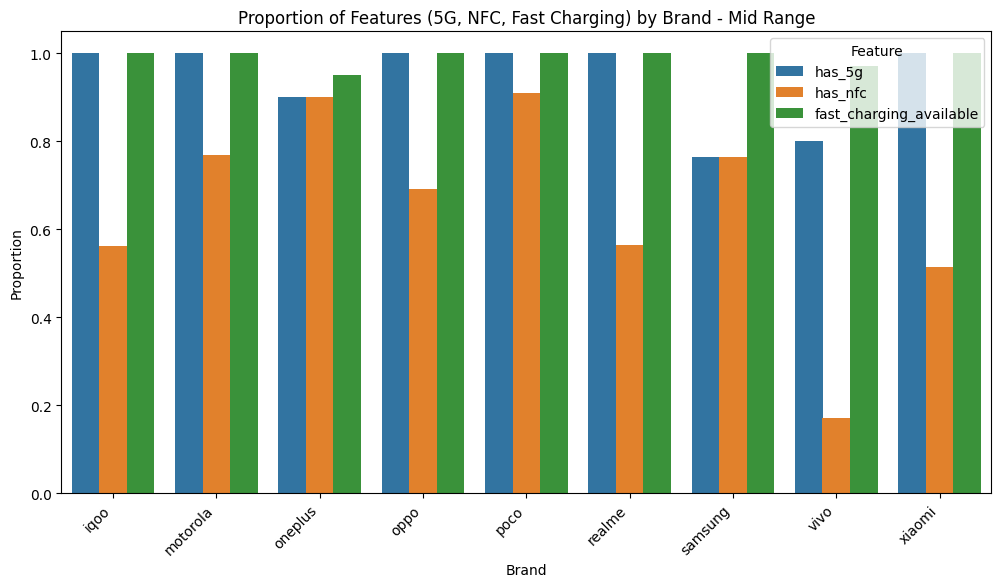

In [14]:
# 5G,nfc and fast_charging for mid

plt.figure(figsize=(12, 6))

sns.barplot(
    data=(
        mid[mid['brand_name'].isin(mid['brand_name'].value_counts()[mid['brand_name'].value_counts() >= 10].index)]
        .groupby(by="brand_name")[['has_5g', 'has_nfc', 'fast_charging_available']]
        .mean()
        .reset_index()
        .melt(id_vars='brand_name', var_name='feature', value_name='proportion')
    ),
    x='brand_name', 
    y='proportion', 
    hue='feature'
)

# Adding labels and title
plt.xticks(rotation=45, ha='right')
plt.title("Proportion of Features (5G, NFC, Fast Charging) by Brand - Mid Range")
plt.ylabel("Proportion")
plt.xlabel("Brand")
plt.legend(title='Feature')

# Show plot
plt.show()

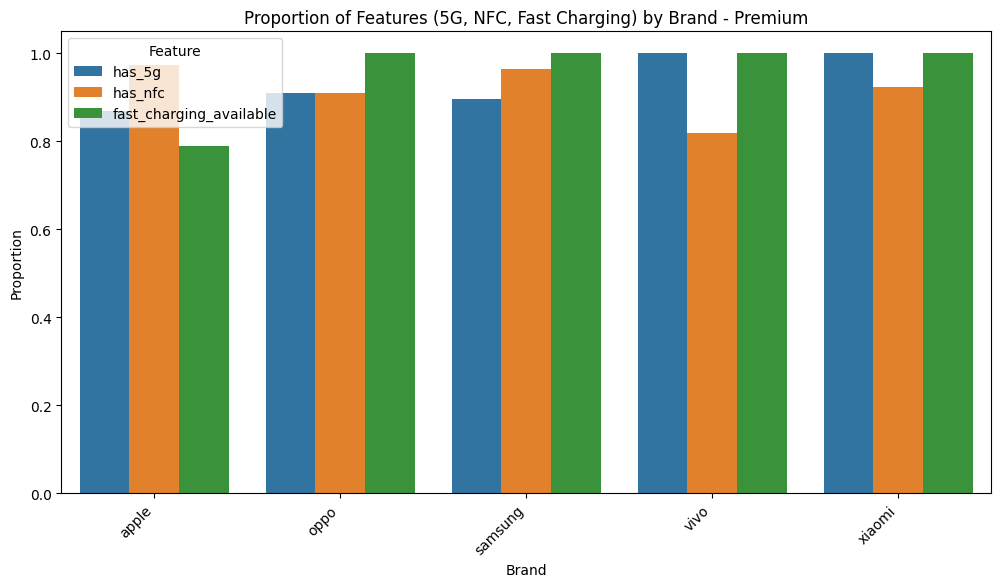

In [15]:
# 5G,nfc and fast_charging for premium

plt.figure(figsize=(12, 6))

sns.barplot(
    data=(
        premium[premium['brand_name'].isin(premium['brand_name'].value_counts()[premium['brand_name'].value_counts() >= 10].index)]
        .groupby(by="brand_name")[['has_5g', 'has_nfc', 'fast_charging_available']]
        .mean()
        .reset_index()
        .melt(id_vars='brand_name', var_name='feature', value_name='proportion')
    ),
    x='brand_name', 
    y='proportion', 
    hue='feature'
)

# Adding labels and title
plt.xticks(rotation=45, ha='right')
plt.title("Proportion of Features (5G, NFC, Fast Charging) by Brand - Premium")
plt.ylabel("Proportion")
plt.xlabel("Brand")
plt.legend(title='Feature')

# Show plot
plt.show()

## Observations

For budget:

- Most brands have 5g in their smartphones although Samsung and Vivo have 5g in less than 80% of smartphones.Itel is performing poorly in all three features.
- Very less phones have NFC feature.Oneplus and Motorola phones have highest proportion of NFC of 50% and 58% respectively.
- Fast charging is mostly available for all brands.Iqoo and Oneplus have fast charging in all smartphones.

For mid range:

- Iqoo and Oneplus have 5g in all smartphones.
- Very less phones have NFC feature.Oneplus and Poco phones have highest proportion of NFC of 90% and 95% respectively.
- Fast charging is mostly available for all brands.

For premium:

- Oppo and Samsung have 5g in 90% smartphones.Rest have 100%.
- All Apple phones have NFC.Other brands have 80-90 % NFC coverage.
- Apple phones have fast charging in 79% smartphones.Rest have 100% fast charging coverage.

## Processor Performance by Brand

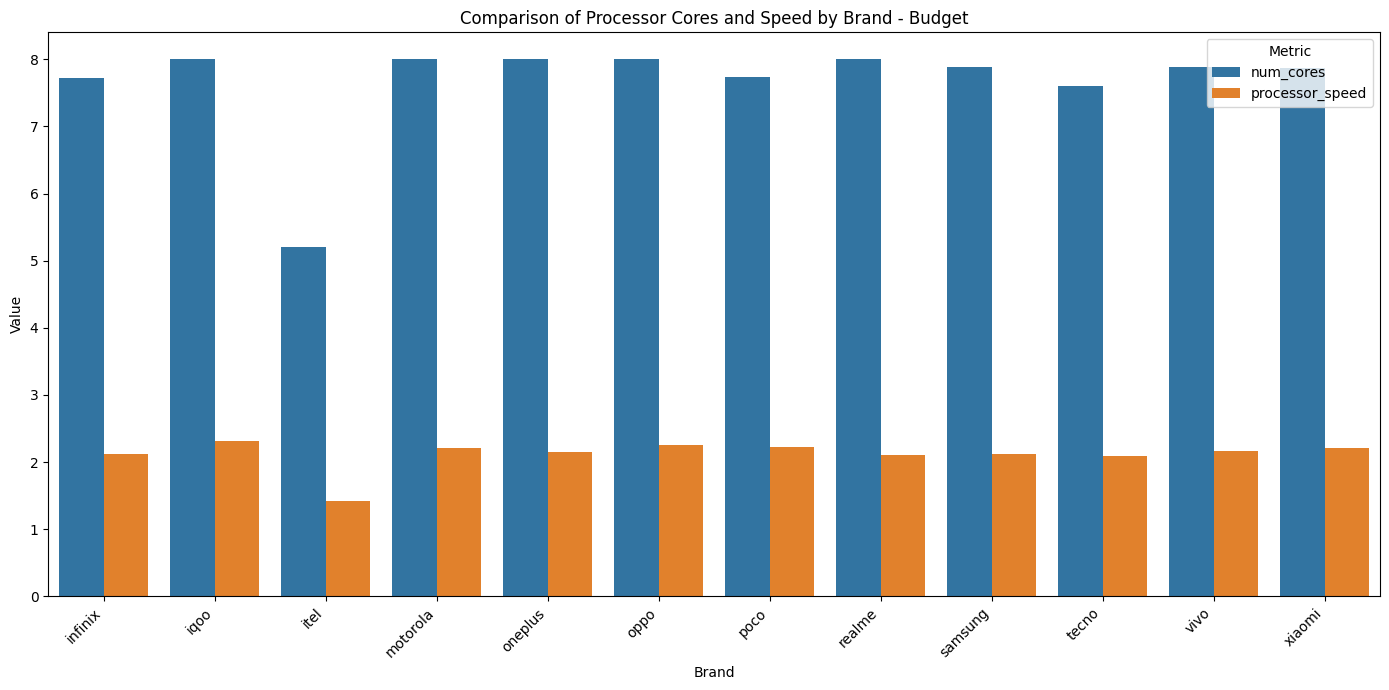

In [16]:
# for budget

data = (
    budget[budget['brand_name'].isin(budget['brand_name'].value_counts()[budget['brand_name'].value_counts() >= 10].index)]
    .groupby(['brand_name'])[['num_cores', 'processor_speed']]
    .agg({'num_cores': 'mean', 'processor_speed': 'mean'})
    .reset_index()
    .melt(id_vars='brand_name', 
          value_vars=['num_cores', 'processor_speed'], 
          var_name='Metric', 
          value_name='Value')
)

# Plot num_cores and processor_speed
plt.figure(figsize=(14, 7))
sns.barplot(
    data=data,
    x='brand_name',
    y='Value',
    hue='Metric',
    errorbar=None
)

plt.xticks(rotation=45, ha='right')
plt.title("Comparison of Processor Cores and Speed by Brand - Budget")
plt.ylabel("Value")
plt.xlabel("Brand")
plt.legend(title="Metric")
plt.tight_layout()

plt.show()


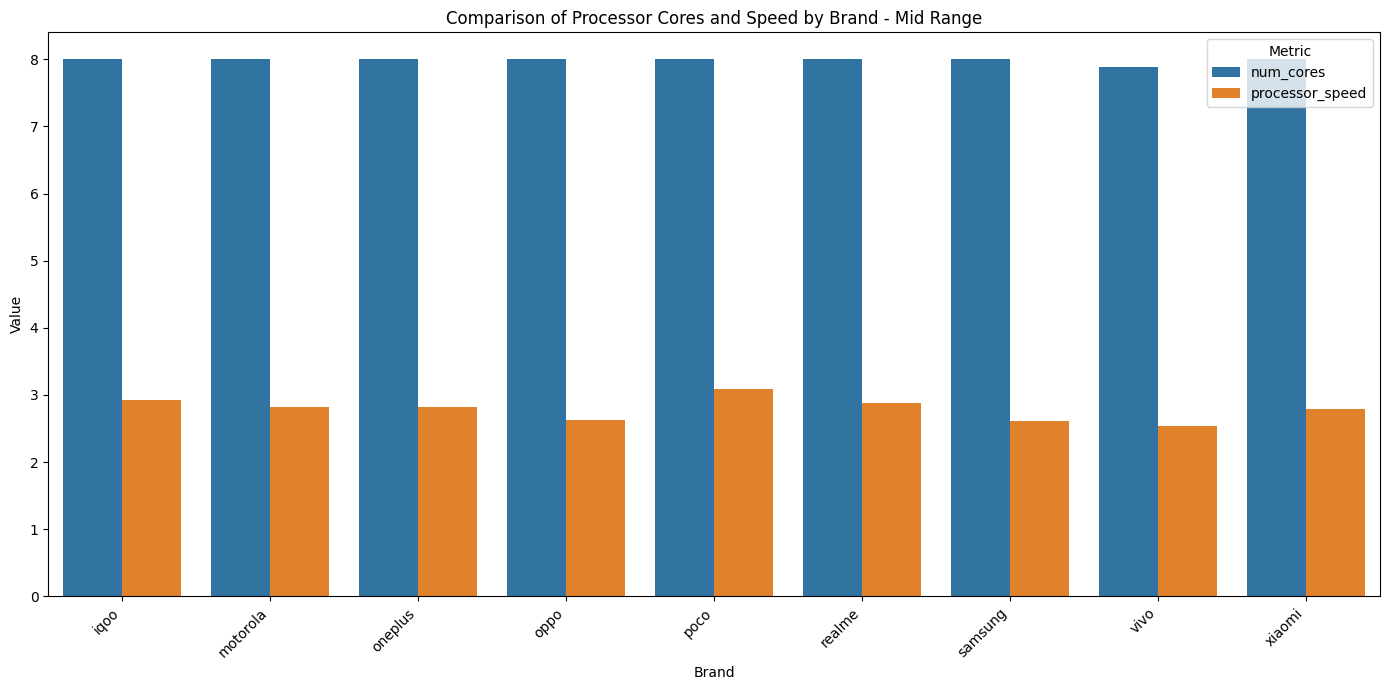

In [17]:
# for mid range

data = (
    mid[mid['brand_name'].isin(mid['brand_name'].value_counts()[mid['brand_name'].value_counts() >= 10].index)]
    .groupby(['brand_name'])[['num_cores', 'processor_speed']]
    .agg({'num_cores': 'mean', 'processor_speed': 'mean'})
    .reset_index()
    .melt(id_vars='brand_name', 
          value_vars=['num_cores', 'processor_speed'], 
          var_name='Metric', 
          value_name='Value')
)

# Plot num_cores and processor_speed
plt.figure(figsize=(14, 7))
sns.barplot(
    data=data,
    x='brand_name',
    y='Value',
    hue='Metric',
    errorbar=None
)

plt.xticks(rotation=45, ha='right')
plt.title("Comparison of Processor Cores and Speed by Brand - Mid Range")
plt.ylabel("Value")
plt.xlabel("Brand")
plt.legend(title="Metric")
plt.tight_layout()

plt.show()


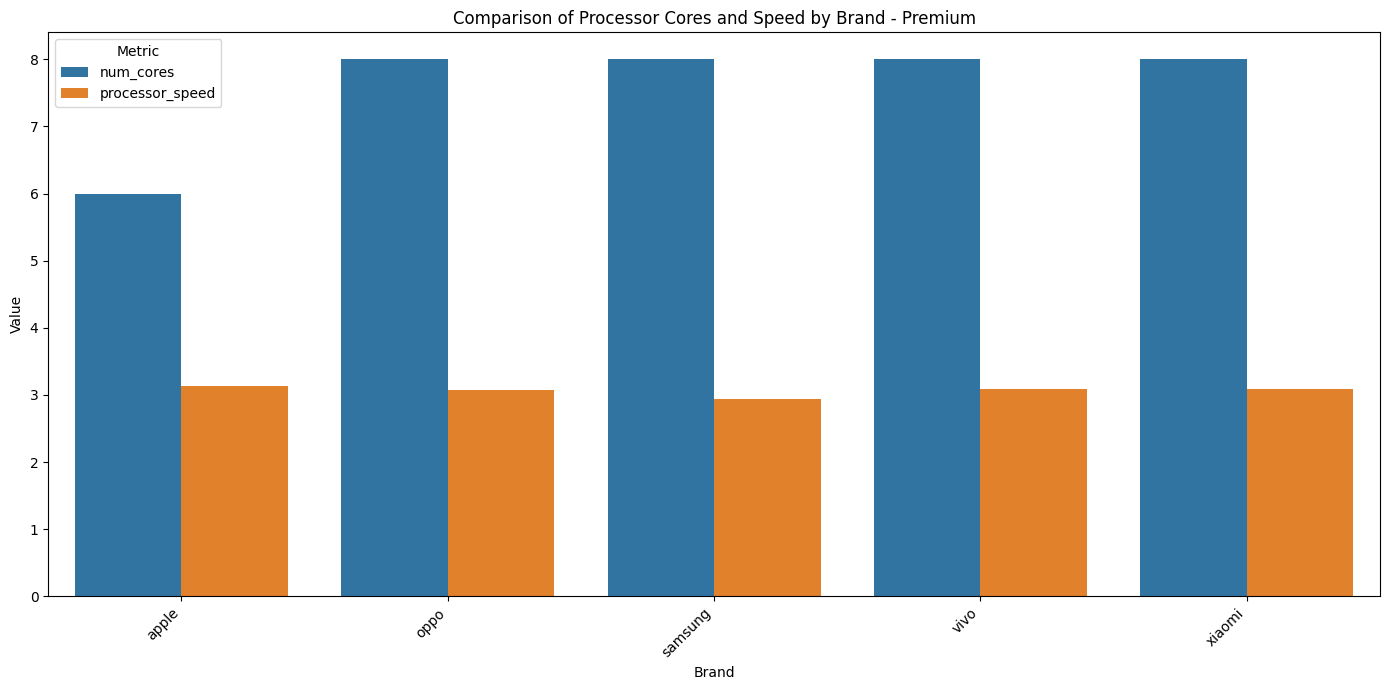

In [18]:
# for premium

data = (
    premium[premium['brand_name'].isin(premium['brand_name'].value_counts()[premium['brand_name'].value_counts() >= 10].index)]
    .groupby(['brand_name'])[['num_cores', 'processor_speed']]
    .agg({'num_cores': 'mean', 'processor_speed': 'mean'})
    .reset_index()
    .melt(id_vars='brand_name', 
          value_vars=['num_cores', 'processor_speed'], 
          var_name='Metric', 
          value_name='Value')
)

# Plot num_cores and processor_speed
plt.figure(figsize=(14, 7))
sns.barplot(
    data=data,
    x='brand_name',
    y='Value',
    hue='Metric',
    errorbar=None
)

plt.xticks(rotation=45, ha='right')
plt.title("Comparison of Processor Cores and Speed by Brand - Premium")
plt.ylabel("Value")
plt.xlabel("Brand")
plt.legend(title="Metric")
plt.tight_layout()

plt.show()

## Observations

For budget:

- Itel is lagging in both number of cores and processor speed.Oppo, Poco and Iqoo have highest average processor speed.

For mid range:

- Average Number of cores are more or less same for every brands.Poco has highest average processor speed followed by Realme, Iqoo and Xiaomi.

For premium:

- Apple has average number of cores as 6 compared to 8 in other brands.In terms average processor speed, Apple and Oppo have highest.

# Price Comparison for Similar Features

## Assumptions

- Only phones without Unknown resolution is considered.

- Minimum number of smartphones for each feature group across segments.

    - Budget :5
  
    - Mid range : 10
  
    - Budget : 15

In [19]:
feature_combination = ["model",
                       "price",
                       "brand_name",
                       "has_5g", 
                       "ram_capacity", 
                       "internal_memory",
                       "fast_charging_available",
                       "resolution",
                       "refresh_rate",
                       "primary_camera_rear"
                      ]

In [20]:
# Function to extract the first number and map to display type

def map_resolution_to_display(series: pd.Series) -> pd.Series:
    """
    Maps a pandas Series of screen resolutions to display types based on the horizontal resolution.

    Args:
        series (pd.Series): A pandas Series containing resolution strings in the format 'WxH',
                            where W and H are integers (e.g., '1440x3216').

    Returns:
        pd.Series: A pandas Series where each resolution is mapped to a display type:
                   - "HD Ready" for 720
                   - "Full HD" for 1080
                   - "Quad HD" for 1440
                   - "Ultra HD (4K)" for 2160
                   Any resolution not matching these values is labeled as "Unknown".
    """
    # Extract the first number as an integer
    first_numbers = series.str.split('x').str[0].astype(int)
    
    # Map based on the guide
    return first_numbers.map({
        720: "HD Ready",
        1080: "Full HD",
        1440: "Quad HD",
        2160: "Ultra HD (4K)"
    }).fillna("Unknown")

In [21]:
price_comparison_df_bud = (
    budget[feature_combination]
    .assign(
        resolution = lambda df_:(
                        df_
                        .resolution
                        .pipe(map_resolution_to_display)
                    )
    )
)

In [22]:
price_comparison_df_mid = (
    mid[feature_combination]
    .assign(
        resolution = lambda df_:(
                        df_
                        .resolution
                        .pipe(map_resolution_to_display)
                    )
    )
)

In [23]:
price_comparison_df_pre = (
    premium[feature_combination]
    .assign(
        resolution = lambda df_:(
                        df_
                        .resolution
                        .pipe(map_resolution_to_display)
                    )
    )
)

In [24]:
feature_combination[2:]

['brand_name',
 'has_5g',
 'ram_capacity',
 'internal_memory',
 'fast_charging_available',
 'resolution',
 'refresh_rate',
 'primary_camera_rear']

### Budget

<Figure size 1600x800 with 0 Axes>

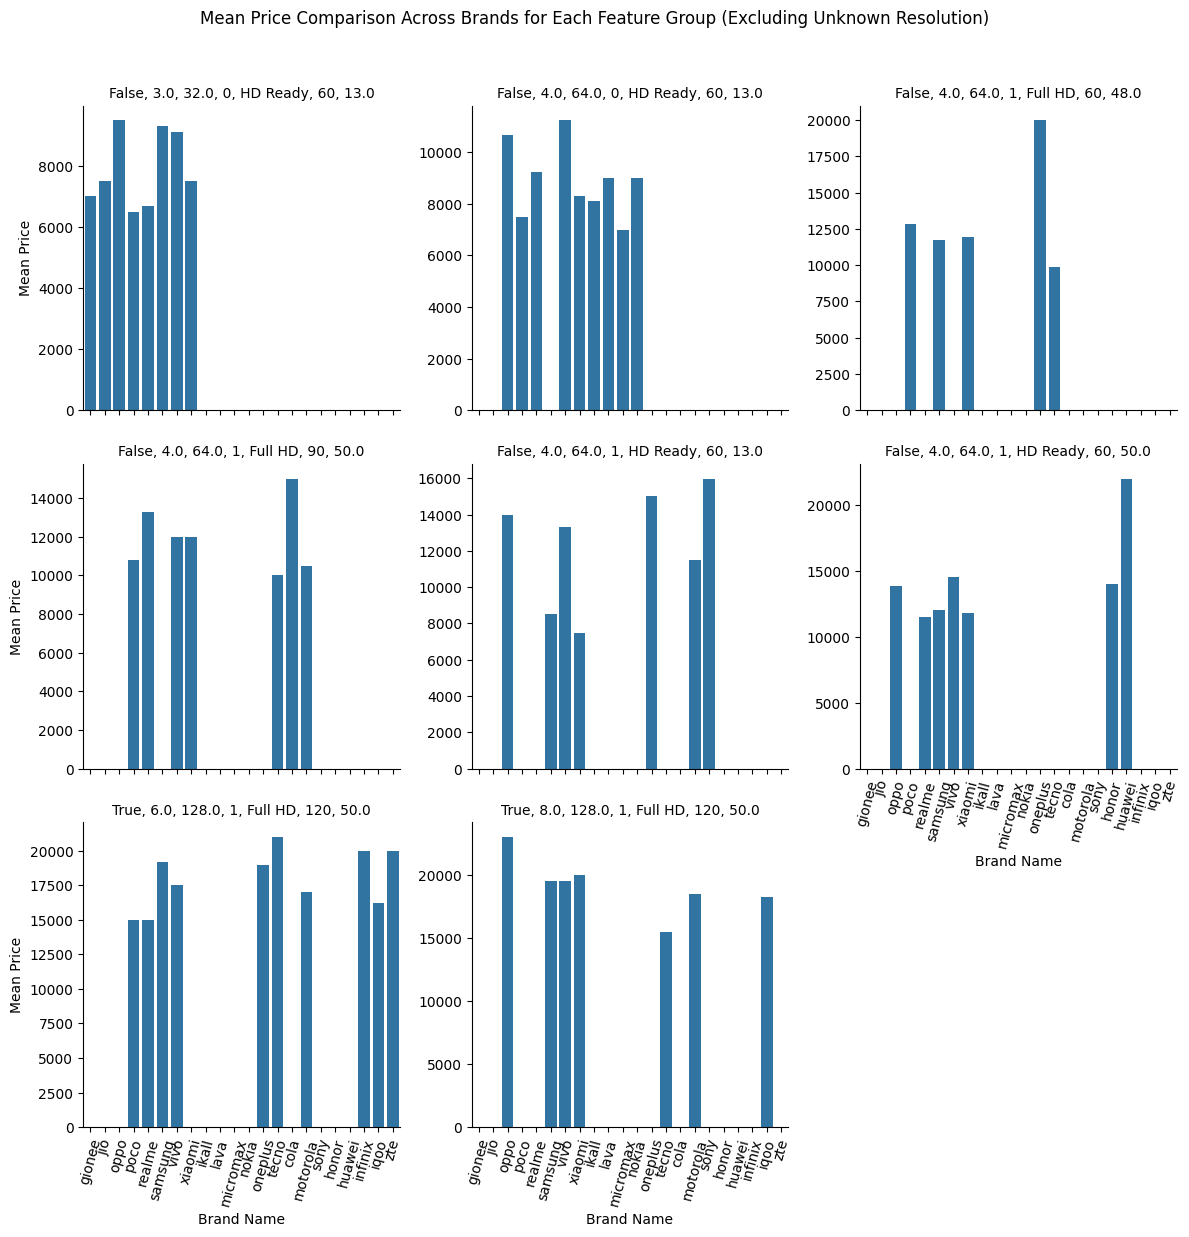

In [25]:
# for budget

data = (
    price_comparison_df_bud
    .query("resolution != 'Unknown'")  
    .groupby(feature_combination[3:])  
    .filter(lambda x: len(x) >= 10)     
    .groupby(feature_combination[3:] + ['brand_name'], as_index=False)  
    .agg(mean_price=('price', 'mean')) 
    .assign(
        feature_group=lambda df: df[feature_combination[3:]].astype(str).agg(", ".join, axis=1)
    )
)


plt.figure(figsize=(16, 8))
# Create FacetGrid for feature group visualization
g = sns.FacetGrid(data, col="feature_group", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.barplot, x="brand_name", y="mean_price", order=data['brand_name'].unique())

# Adjust labels and titles
g.set_titles("{col_name}")
g.set_axis_labels("Brand Name", "Mean Price")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(75)  

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Mean Price Comparison Across Brands for Each Feature Group (Excluding Unknown Resolution)")
plt.show()

### Mid Range

<Figure size 1600x800 with 0 Axes>

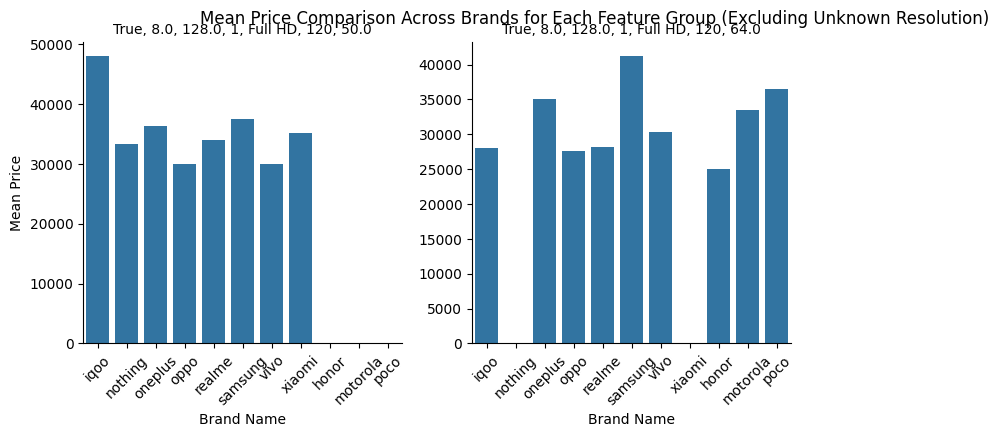

In [26]:
# for mid range

data = (
    price_comparison_df_mid
    .query("resolution != 'Unknown'") 
    .groupby(feature_combination[3:])  
    .filter(lambda x: len(x) >= 15)     
    .groupby(feature_combination[3:] + ['brand_name'], as_index=False) 
    .agg(mean_price=('price', 'mean'))  
    .assign(
        feature_group=lambda df: df[feature_combination[3:]].astype(str).agg(", ".join, axis=1)
    )
)


plt.figure(figsize=(16, 8))
# Create FacetGrid for feature group visualization
g = sns.FacetGrid(data, col="feature_group", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.barplot, x="brand_name", y="mean_price", order=data['brand_name'].unique())

# Adjust labels and titles
g.set_titles("{col_name}")
g.set_axis_labels("Brand Name", "Mean Price")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)  # Rotate x-axis labels for better readability

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Mean Price Comparison Across Brands for Each Feature Group (Excluding Unknown Resolution)")
plt.show()

### Premium

<Figure size 1600x800 with 0 Axes>

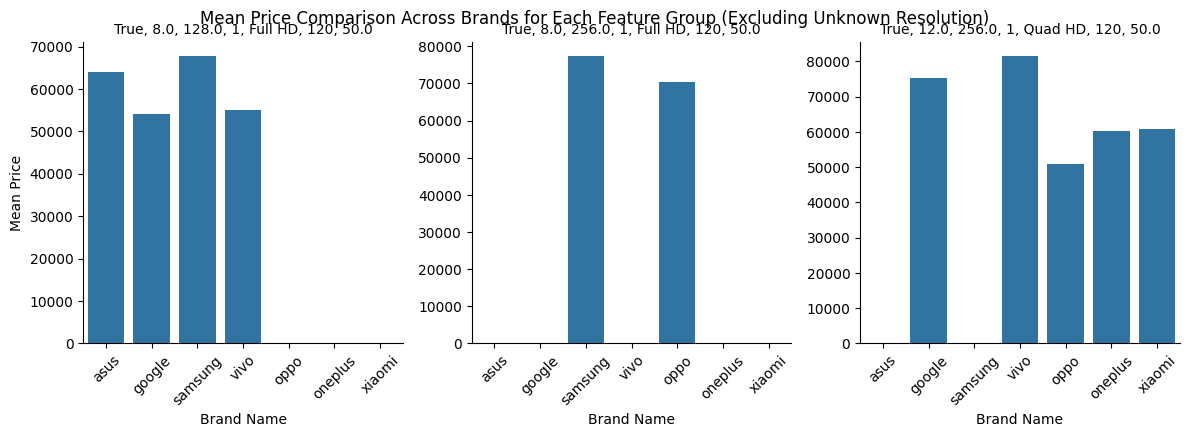

In [27]:
# for premium

data = (
    price_comparison_df_pre
    .query("resolution != 'Unknown'") 
    .groupby(feature_combination[3:])  
    .filter(lambda x: len(x) >= 5)    
    .groupby(feature_combination[3:] + ['brand_name'], as_index=False) 
    .agg(mean_price=('price', 'mean'))  
    .assign(
        feature_group=lambda df: df[feature_combination[3:]].astype(str).agg(", ".join, axis=1)
    )
)


plt.figure(figsize=(16, 8))
# Create FacetGrid for feature group visualization
g = sns.FacetGrid(data, col="feature_group", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.barplot, x="brand_name", y="mean_price", order=data['brand_name'].unique())

# Adjust labels and titles
g.set_titles("{col_name}")
g.set_axis_labels("Brand Name", "Mean Price")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45) 

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Mean Price Comparison Across Brands for Each Feature Group (Excluding Unknown Resolution)")
plt.show()

## Observations

For budget:

- Oppo, samsung, Vivo -> 3, 32, 13
- Oppo and Vivo -> 4, 64, 13
- Poco and Cola -> 4, 64, 48
- Cola -> 4, 64, 90, 50
- Oppo, Oneplus and Sony -> 4, 64, 13 with fast charging
- Huwaei -> 4, 64, 50 with fast charging
- Oneplus, Tecno, Infinix, Iqoo, Zte  -> 6, 128, 120, 50
- Oppo -> 8, 128, 120, 50

For mid range:

- Iqoo has highest average price (47000) with 50 MP primary rear camera others are more or less similar.
- Samsung has highest average price (42000) with 64 MP primary rear camera followed by Poco(37000) and Oneplus (35000).


For premium:

- Samsung has highest average price (68000), Asus(63000) , Google and Vivo (53000) for the 50MP  primary rear camera.